# response-level.ipynb
## Author: Elliot Pallister

Notebook for response-level analysis in the Pareto project

In [2]:
# Collecting necessary imports

# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Internal imports
from pareto.data_io import get_cache, get_session, get_unit_channels, get_spike_times, get_stimulus_presentations, get_units_by_area, get_trials
from pareto.preprocessing import make_psth_cube, get_image_trials, arrange_image_onsets_to_trial, group_stims_by_frame_index
from pareto.stats import visual_selectivity_filter, subtract_baseline, zscore, roc_analysis
from pareto.plotting import plot_pop_mean, mean_variance_scatter

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Importing the cache from AllenSDK
cache = get_cache()

# Using session ID 1044385384
session_id = 1044385384
session = get_session(session_id)

units = get_unit_channels(session)
trials = get_trials(session)
stimulus_presentations = get_stimulus_presentations(session)
spike_times = get_spike_times(session)

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Firstly, I want to filter my units based on:

1. Quality metrics (SNR, interspike interval violations and firing rate)
2. Area (starting with VISp)

In [4]:
quality_unit_filter = ((units['snr'] >= 1) & (units['isi_violations'] < 1) & (units['firing_rate'] > 0.1))
quality_units = units.loc[quality_unit_filter].copy()

area_of_interest = ['VISp']
area_units = get_units_by_area(quality_units, area_of_interest)

print(f'Number of filtered units in {area_of_interest}: {area_units.shape[0]}')


Number of filtered units in ['VISp']: 84


Next, I want to find the stimulus onsets for the image with id: im036_r.

I will use these onsets to:

1. Statistically test the unit responses for selectivity to the image, calculating effect sizes and p values, using a Wilcoxon paired rank test
2. Update the area units dataframe to contain effect sizes and p values in a column
3. Filter the area units by selectivity for the stimulus

In [5]:
stim_of_interest = 'im036_r'
stim_onsets = stimulus_presentations[stimulus_presentations['image_name'] == stim_of_interest]['start_time'].values

# Define the time before the image and the duration of the window during which spikes are counts
time_before_stim = 0.25
duration = 0.5

# Statistical testing
selectivity_mask, effects, p_values = visual_selectivity_filter(area_units, spike_times, stim_onsets, time_before_stim, duration)

area_units = area_units.copy()

# Assigning effect size and p_values
area_units.loc[:, 'p_values'] = p_values
area_units.loc[:, 'effect_size'] = effects

visual_area_units = area_units[selectivity_mask]

print(f'Number of units selective for {stim_of_interest} in {area_of_interest}: {visual_area_units.shape[0]}')

Number of units selective for im036_r in ['VISp']: 54


Next I want to produce a cube of dimensions U x O x T where U is the unit, O is the onset time and T is the time bin (50ms) within a set window around stimulus onset

In [6]:
pre_onset_post_end = (0.25, 0, 0.25, 0.5)

cube, unit_ids, bins = make_psth_cube(visual_area_units, spike_times, stim_onsets, pre_onset_post_end, bin_size=0.01)
bins = bins[:-1]

print(isinstance(cube, np.ndarray))
print(cube.ndim)
print(cube.shape)

True
3
(54, 1064, 75)


Now that I have all of the individual data points, I will begin by baseline subtracting and z-scoring each of these traces and extract some information out by plotting a few important parameters. Here are the following questions I am looking to answer:

1. What is the distribution of mean firing rate taken across all stimulus presentations across all units?
2. What is the variance of firing rate and what is the distribution of this across the population?

[ 0 25]


Text(0.5, 1.0, 'Ranked variance across units')

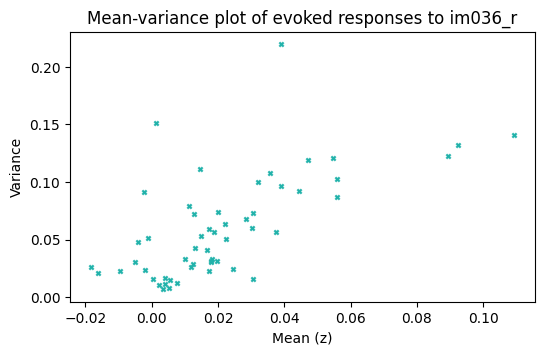

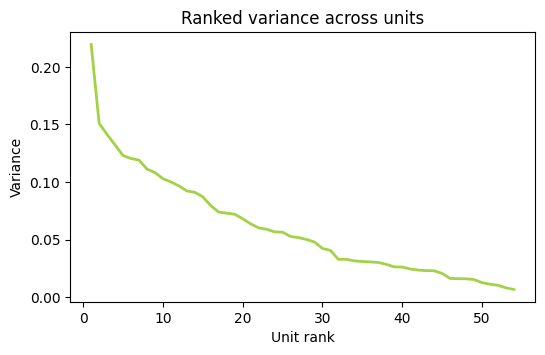

In [7]:
baseline_window = [-0.25, 0]
baseline_window = np.array(baseline_window)

bsub = subtract_baseline(cube, baseline_window, bins)

zs, mu, std = zscore(bsub)
mu = np.squeeze(mu)
std = np.squeeze(std)

evoked_window = np.array([0, 0.25])
evoked_indices = np.searchsorted(bins, evoked_window)
means = mu[:, evoked_indices[0]:evoked_indices[1]].mean(axis=1)
variances = std[:, evoked_indices[0]:evoked_indices[1]].mean(axis=1) ** 2

fig, ax = plt.subplots(figsize=(6, 3.5))

ax.scatter(means, variances, s=15, c='lightseagreen', marker='X', linewidths=0.2)
ax.set_xlabel("Mean (z)")
ax.set_ylabel("Variance")
ax.set_title("Mean-variance plot of evoked responses to im036_r")

order_variances = np.argsort(variances)[::-1]
ranked_variances = variances[order_variances]
order_means = np.argsort(means)[::-1]
ranked_means = means[order_means]

x = np.arange(1, ranked_variances.size + 1)

fig1, ax1 = plt.subplots(figsize=(6, 3.5))
ax1.plot(x, ranked_variances, lw=2, alpha=0.9, color='yellowgreen')
ax1.set_xlabel("Unit rank")
ax1.set_ylabel("Variance")
ax1.set_title("Ranked variance across units")

 

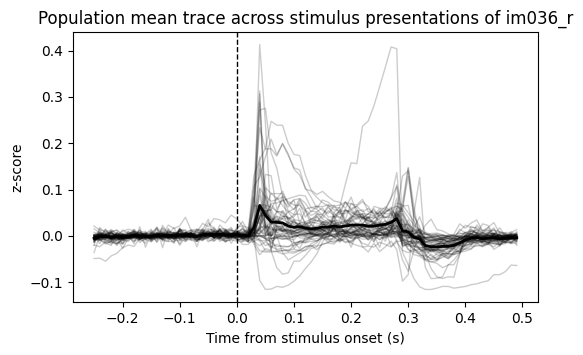

In [35]:
fig1, ax1 = plot_pop_mean(mu, bins)

Next, I will perform an ROC analysis on the evoked responses for each unit in the population to repeated presentations of im036_r. 

Here I am going to do the following:

1. Obtain a evoked response vector, and split it into non-overlapping chunks of 20 for each unit.
2. Visualise a heatmap of the mean ROC curve for unit in the population, ranking the units in descending order.

In [9]:
evoked_responses = bsub[:,:,evoked_indices[0]:evoked_indices[1]].mean(axis=2)

def auc_roc(responses, chunk_size):

  n_chunks = int(round(responses.shape[1]/chunk_size))

  unit_chunks = []

  for unit in responses:

    chunks = []

    for i in range(n_chunks):
      chunk = unit[i*20:(i+1)*20]
      chunks.append(chunk)
  
    chunks = np.array(chunks)
    unit_chunks.append(chunks)

  unit_chunks = np.array(unit_chunks)

  unit_TPRs, unit_FPRs, unit_AUCs = [], [], []

  for unit in unit_chunks:

    TPRs, FPRs, AUCs = [], [], []

    for c in range(n_chunks-1):

      TPR, FPR = roc_analysis(unit[0], unit[c+1])
      TPR, FPR = np.array(TPR), np.array(FPR)
      TPRs.append(TPR)
      FPRs.append(FPR)
      order = np.argsort(FPR)
      auc = np.trapz(TPR[order], FPR[order]) 
      if auc < 0.5:
        auc = 1 - auc
      AUCs.append(auc)

    TPRs, FPRs, AUCs = np.array(TPRs), np.array(FPRs), np.array(AUCs)
    unit_TPRs.append(TPRs)
    unit_FPRs.append(FPRs)
    unit_AUCs.append(AUCs)

  unit_TPRs, unit_FPRs, unit_AUCs = np.array(unit_TPRs), np.array(unit_FPRs), np.array(unit_AUCs)

  return unit_TPRs, unit_FPRs, unit_AUCs


unit_TPRs, unit_FPRs, unit_AUCs = auc_roc(evoked_responses, 20)

print(unit_AUCs.shape)
print(unit_AUCs)

(54, 52)
[[0.54    0.565   0.50125 ... 0.5125  0.57875 0.66375]
 [0.56875 0.59375 0.54625 ... 0.715   0.7575  0.67625]
 [0.5675  0.75    0.51625 ... 0.61625 0.6325  0.585  ]
 ...
 [0.58125 0.54125 0.5325  ... 0.69125 0.5025  0.52625]
 [0.5275  0.59125 0.525   ... 0.56125 0.61375 0.51875]
 [0.58375 0.565   0.5925  ... 0.64375 0.54875 0.56125]]


Text(0.5, 1.0, 'Heatmap of AUC to repeated presentations of im036_r across VISp population (compared to first)')

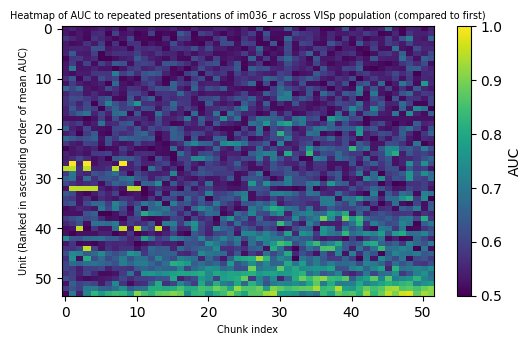

In [10]:
# ordering units from most to least stable

mean_AUCs = unit_AUCs.mean(axis=1)
ranked_order = np.argsort(mean_AUCs)
ordered_AUCs = unit_AUCs[ranked_order,:]

fig, ax = plt.subplots(figsize=(6, 3.5))

im = ax.imshow(ordered_AUCs, cmap='viridis', aspect='auto')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("AUC")

ax.set_xlabel("Chunk index", fontsize=7)
ax.set_ylabel("Unit (Ranked in ascending order of mean AUC)", fontsize=7)
ax.set_title("Heatmap of AUC to repeated presentations of im036_r across VISp population (compared to first)", fontsize=7)




I want to now extend the frame-wise logic to the ROC analysis, looking at how the responses change across each of the trial frames for the first 6 frames.

The Area Under Curve (AUC) is 0.5921875


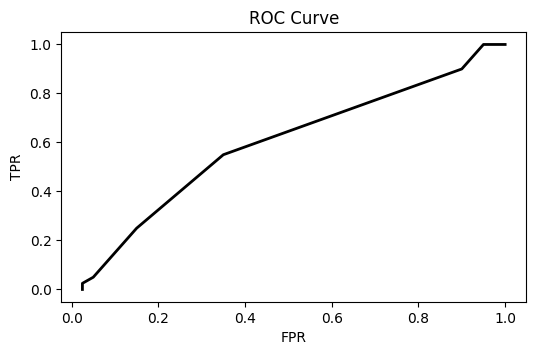

In [33]:
image_trials = get_image_trials(trials, stim_of_interest, stim_onsets)
trial_frame_onsets = arrange_image_onsets_to_trial(image_trials)
grouped_trial_frame_onsets = group_stims_by_frame_index(trial_frame_onsets)

def find_onset_indices(frame_onsets, onsets):

  onset_indices = []

  for _, row in frame_onsets.iterrows():
    io = np.searchsorted(onsets, row["onsets"])
    io = np.array(io)
    onset_indices.append(io)
  
  return onset_indices

onset_indices = find_onset_indices(grouped_trial_frame_onsets, stim_onsets)

def frame_evoked_responses(responses, onset_indices):

  ufrs = []

  for unit in range(responses.shape[0]):

    fers = []

    for i in range(0, 6):
      
      frame = onset_indices[i]
      fer = responses[unit, frame, evoked_indices[0]:evoked_indices[1]].mean(axis=1)
      fers.append(fer)
    
    ufrs.append(fers)
  
  return ufrs

unit_frame_responses = frame_evoked_responses(bsub, onset_indices)

# Checking logic on the first and second frames for the first unit, visualising the ROC curve

TPR, FPR = roc_analysis(unit_frame_responses[0][0], unit_frame_responses[0][1])

fig, ax = plt.subplots(figsize=(6, 3.5))

ax.plot(FPR, TPR, color='k', lw=2)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC Curve")

order = np.argsort(FPR)
auc = np.trapz(TPR[order], FPR[order])

print(f'The Area Under Curve (AUC) is {auc}')
